In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sparse
from scipy.sparse.linalg import eigsh, expm_multiply, expm

### Correlator generalized for L sites

In [7]:
def gen_spin_operators(L):
    """Returns the spin-1/2 operators sigma_x and sigma_z for L sites."""
    X = sparse.csr_array(np.array([[0.,1.],[1.,0.]]))
    Z = sparse.csr_array(np.diag([1.,-1.]))
    
    d = 2
    Sx_list = []
    Sz_list = []
    
    for i_site in range(L):
        # ops on first site
        if i_site == 0: 
            Sx = X
            Sz = Z 
        else: 
            Sx = sparse.csr_array(np.eye(d))
            Sz = sparse.csr_array(np.eye(d))
        # ops on remaining sites
        for j_site in range(1, L):
            if j_site == i_site: 
                Sx = sparse.kron(Sx, X, 'csr')
                Sz = sparse.kron(Sz, Z, 'csr')
            else:
                Sx = sparse.kron(Sx, np.eye(d), 'csr')
                Sz = sparse.kron(Sz, np.eye(d), 'csr')
        Sx_list.append(Sx)
        Sz_list.append(Sz)
    
    return Sx_list, Sz_list

def gen_hamiltonian_terms(L, Sx_list, Sz_list):
    """Generates the XX and Z terms of the Hamiltonian."""
    D = Sx_list[0].shape[0]
    print(f'System with {L:d} sites, Hilbert space dimension is {D:d}.')

    # Ising interaction
    Hxx = Sx_list[0] @ Sx_list[1]
    for i in range(1, L-1):
        Hxx += Sx_list[i] @ Sx_list[i+1]

    Hzz = Sz_list[0] @ Sz_list[1]
    for i in range(1, L-1):
        Hzz += Sz_list[i] @ Sz_list[i+1]

    Hx = Sx_list[0]
    for Sx in Sx_list[1:L]:
        Hx += Sx

    # onsite field terms
    Hz = Sz_list[0]
    for Sz in Sz_list[1:L]:
        Hz += Sz
    
    return Hxx, Hzz, Hx, Hz

In [49]:
# define Hamiltonian terms
L = 11
J = 1.
g = 0.5    
k = 0

Sx_list, Sz_list = gen_spin_operators(L)
Hxx, Hzz, Hx, Hz = gen_hamiltonian_terms(L, Sx_list, Sz_list)

def Ham(h):
    return -J * Hxx -g * Hz - k * Hzz + h * Hx

System with 11 sites, Hilbert space dimension is 2048.


0.9999999999999979


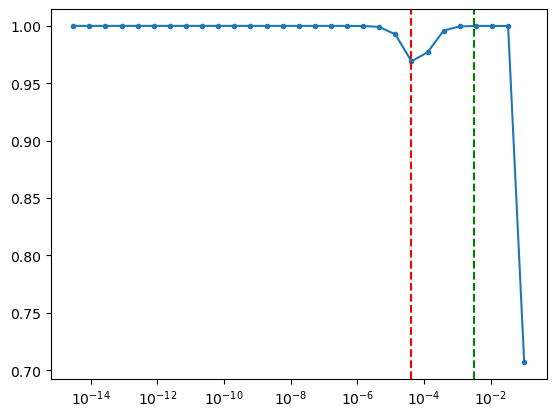

In [67]:
# compute correlator
dt = 1e-2
n = 10
N = 2**n

h_list = np.logspace(-1,-15,30)
#print(h_list)
overlap_psi = []
E, psi = eigsh(Ham(0), k=1, which='SA')
E0, psi = np.squeeze(E), np.squeeze(psi)
psi_0 = psi
psi1 = psi
# get ground state
for h in h_list[1:]:
    E, psi = eigsh(Ham(h), k=1, which='SA')
    E0, psi = np.squeeze(E), np.squeeze(psi)
    overlap_psi.append(np.abs(psi_0.conj() @ psi))
    #print(psi_0.conj() @ psi)
    #print(psi_0)
    psi_0 = psi
    #print(psi)
    #print()

E, psi_h0 = eigsh(Ham(0), k=1, which='SA')
E0, psi_h0 = np.squeeze(E), np.squeeze(psi)

print(np.abs(psi_h0.conj() @ psi1))


plt.plot(h_list[:-1], overlap_psi, '.-')
plt.axvline(x=min_h, color='r', linestyle='--', label='x = 3')
plt.axvline(x=10**-2.5, color='g', linestyle='--', label='x = 3')

plt.xscale("log")

In [65]:

min_index = np.argmin(overlap_psi[1:])
min_h = h_list[min_index+1]
print(min_h)
print(h_list[3])

4.1753189365604006e-05
0.003562247890262444
